Using device: cuda


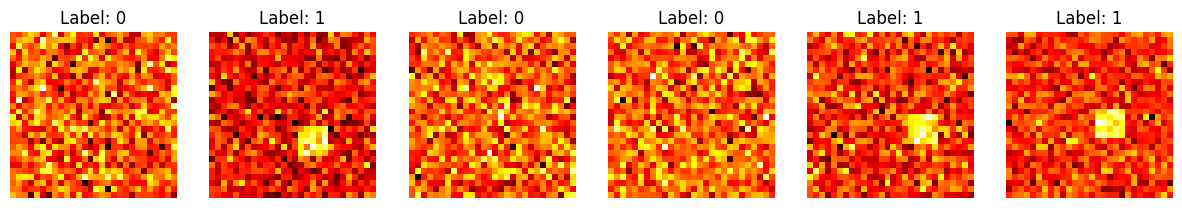

Epoch 1/5, Batch 0, Loss: 0.7157
Epoch 1/5, Batch 10, Loss: 0.7635
Epoch 1/5, Batch 20, Loss: 0.7565
Epoch 1/5, Batch 30, Loss: 0.7954
Epoch 1/5, Batch 40, Loss: 0.7476
Epoch 1/5, Batch 50, Loss: 0.7436
Epoch 1/5, Batch 60, Loss: 0.6670
Epoch 1/5, Batch 70, Loss: 0.7027
Epoch 1/5, Batch 80, Loss: 0.6033
Epoch 1/5, Batch 90, Loss: 0.6695
Epoch 1/5, Batch 100, Loss: 0.7280
Epoch 1/5, Batch 110, Loss: 0.6984
Epoch 1/5, Batch 120, Loss: 0.6485
Epoch 2/5, Batch 0, Loss: 0.6978
Epoch 2/5, Batch 10, Loss: 0.7226
Epoch 2/5, Batch 20, Loss: 0.6975
Epoch 2/5, Batch 30, Loss: 0.6747
Epoch 2/5, Batch 40, Loss: 0.6958
Epoch 2/5, Batch 50, Loss: 0.7295
Epoch 2/5, Batch 60, Loss: 0.6950
Epoch 2/5, Batch 70, Loss: 0.6950
Epoch 2/5, Batch 80, Loss: 0.6950
Epoch 2/5, Batch 90, Loss: 0.7094
Epoch 2/5, Batch 100, Loss: 0.6944
Epoch 2/5, Batch 110, Loss: 0.6556
Epoch 2/5, Batch 120, Loss: 0.6572
Epoch 3/5, Batch 0, Loss: 0.6941
Epoch 3/5, Batch 10, Loss: 0.6941
Epoch 3/5, Batch 20, Loss: 0.6818
Epoch 3/5, 

In [ ]:
# !pip install pennylane torchvision torch numpy matplotlib

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Ensure device is set up (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Generate Synthetic Thermal Breast Cancer Dataset
class SyntheticThermalDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=(28, 28)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.data, self.labels = self.generate_data()

    def generate_data(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            # Generate a random image with Gaussian noise
            image = np.random.normal(0.5, 0.1, self.image_size)
            label = np.random.randint(0, 2)  # Binary label: 0 (healthy) or 1 (cancer)

            # Add a simple pattern to simulate a "tumor" if label is 1
            if label == 1:
                x, y = np.random.randint(10, 18, size=2)
                image[x:x+5, y:y+5] += 0.3  # Brighter region to simulate a hotspot

            # Clip values to be in the range [0, 1]
            image = np.clip(image, 0, 1)
            data.append(image)
            labels.append(label)

        return np.array(data, dtype=np.float32), np.array(labels, dtype=np.int64)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        # Convert image to PyTorch tensor and add channel dimension
        image = torch.tensor(image).unsqueeze(0)
        return image, label

# Instantiate the synthetic dataset and DataLoader
train_dataset = SyntheticThermalDataset(num_samples=1000)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Display a few sample images
def show_samples(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image[0], cmap='hot')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

show_samples(train_dataset)

# 2. Define quantum circuit parameters
n_qubits = 4
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit for the VQC
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Encode classical data into quantum state
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Apply variational layers
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RY(weights[layer][i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Measurement: return expectation values of Pauli Z operators
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# 3. Define the Hybrid Quantum-CNN Model
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        # Fully connected layer for quantum input (output size matches n_qubits)
        self.fc1 = nn.Linear(16 * 5 * 5, n_qubits)

        # Quantum parameters
        self.q_weights = nn.Parameter(torch.randn(n_layers, n_qubits))

        # Fully connected layer for classification
        self.fc2 = nn.Linear(n_qubits, 2)

    def forward(self, x):
        # CNN forward pass
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten and normalize for quantum input
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.tanh(x)  # Normalize input for VQC

        # Quantum circuit forward pass# Quantum circuit forward pass
        q_out = torch.stack([
    torch.tensor(quantum_circuit(x[i], self.q_weights), dtype=torch.float32, device=x.device)
    for i in range(x.size(0))])
        # Fully connected layer for classification
        x = self.fc2(q_out)
        return nn.LogSoftmax(dim=1)(x)

# Move model to device (GPU or CPU)
model = HybridModel().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
n_epochs = 5

for epoch in range(n_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

print("Training complete.")

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install pennylane torchvision torch numpy matplotlib torch-complex

Using device: cuda


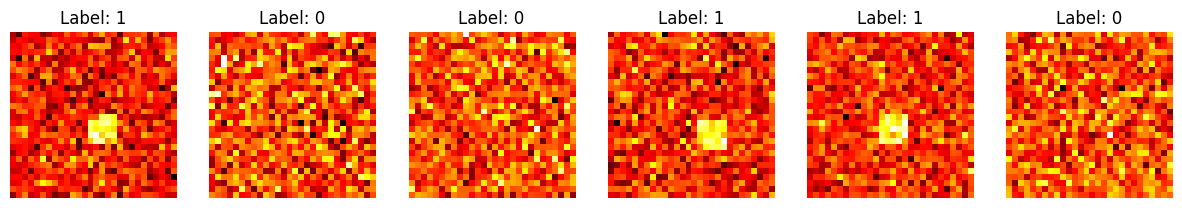

Epoch 1/5, Batch 0, Loss: 0.8959
Epoch 1/5, Batch 10, Loss: 0.6953
Epoch 1/5, Batch 20, Loss: 0.6878
Epoch 1/5, Batch 30, Loss: 0.9681
Epoch 1/5, Batch 40, Loss: 0.7541
Epoch 1/5, Batch 50, Loss: 0.6940
Epoch 1/5, Batch 60, Loss: 0.7047
Epoch 1/5, Batch 70, Loss: 0.6823
Epoch 1/5, Batch 80, Loss: 0.6837
Epoch 1/5, Batch 90, Loss: 0.5896
Epoch 1/5, Batch 100, Loss: 0.5900
Epoch 1/5, Batch 110, Loss: 0.5564
Epoch 1/5, Batch 120, Loss: 0.5603
Epoch 2/5, Batch 0, Loss: 0.4779
Epoch 2/5, Batch 10, Loss: 0.4215
Epoch 2/5, Batch 20, Loss: 0.4048
Epoch 2/5, Batch 30, Loss: 0.1937
Epoch 2/5, Batch 40, Loss: 0.1112
Epoch 2/5, Batch 50, Loss: 0.1718
Epoch 2/5, Batch 60, Loss: 0.0799
Epoch 2/5, Batch 70, Loss: 0.0844
Epoch 2/5, Batch 80, Loss: 0.0503
Epoch 2/5, Batch 90, Loss: 0.0234
Epoch 2/5, Batch 100, Loss: 0.0409
Epoch 2/5, Batch 110, Loss: 0.0306
Epoch 2/5, Batch 120, Loss: 0.0251
Epoch 3/5, Batch 0, Loss: 0.0143
Epoch 3/5, Batch 10, Loss: 0.0210
Epoch 3/5, Batch 20, Loss: 0.0189
Epoch 3/5, 

In [ ]:
# Install dependencies

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
from pennylane import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from torch_complex import ComplexTensor

# Ensure device is set up (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Generate Synthetic Thermal Breast Cancer Dataset
class SyntheticThermalDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=(28, 28)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.data, self.labels = self.generate_data()

    def generate_data(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            # Generate a random image with Gaussian noise
            image = np.random.normal(0.5, 0.1, self.image_size)
            label = np.random.randint(0, 2)  # Binary label: 0 (healthy) or 1 (cancer)

            # Add a simple pattern to simulate a "tumor" if label is 1
            if label == 1:
                x, y = np.random.randint(10, 18, size=2)
                image[x:x+5, y:y+5] += 0.3  # Brighter region to simulate a hotspot

            # Clip values to be in the range [0, 1]
            image = np.clip(image, 0, 1)
            data.append(image)
            labels.append(label)

        return np.array(data, dtype=np.float32), np.array(labels, dtype=np.int64)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        # Convert image to PyTorch tensor and add channel dimension
        image = torch.tensor(image).unsqueeze(0)  # Shape: [1, height, width]
        return image, label
# Instantiate the synthetic dataset and DataLoader
train_dataset = SyntheticThermalDataset(num_samples=1000)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Display a few sample images
def show_samples(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image[0], cmap='hot')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

show_samples(train_dataset)

# 2. Define Complex-Valued Operations
class ComplexConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ComplexConv2d, self).__init__()
        self.real = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.imag = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        # Split into real and imaginary parts
        real, imag = x[:, 0], x[:, 1]
        real_out = self.real(real) - self.imag(imag)
        imag_out = self.real(imag) + self.imag(real)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(ComplexLinear, self).__init__()
        self.real = nn.Linear(in_features, out_features)
        self.imag = nn.Linear(in_features, out_features)

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.real(real) - self.imag(imag)
        imag_out = self.real(imag) + self.imag(real)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexActivation(nn.Module):
    def __init__(self, activation_func):
        super(ComplexActivation, self).__init__()
        self.activation_func = activation_func

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.activation_func(real)
        imag_out = self.activation_func(imag)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexMagnitude(nn.Module):
    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        return torch.sqrt(real**2 + imag**2)

# 3. Define the Complex-Valued CNN Model
# 3. Define the Complex-Valued CNN Model
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()

        # Complex convolutional layers
        self.conv1 = ComplexConv2d(1, 8, kernel_size=3, stride=1)
        self.conv2 = ComplexConv2d(8, 16, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(2)
        self.activation = ComplexActivation(nn.ReLU())

        # Fully connected layers
        self.fc1 = ComplexLinear(16 * 5 * 5, 10)
        self.fc2 = nn.Linear(10, 2)  # Final real-valued output

        self.magnitude = ComplexMagnitude()

    def forward(self, x):
        # Add imaginary channel (set to 0 initially for real-valued input)
        x = torch.stack([x, torch.zeros_like(x)], dim=1)

        # Complex convolutional layers
        x = self.conv1(x)
        x = self.activation(x)
        # Apply max pooling to real and imaginary parts separately
        x = torch.stack([self.pool(x[:, 0]), self.pool(x[:, 1])], dim=1)
        x = self.conv2(x)
        x = self.activation(x)
        # Apply max pooling to real and imaginary parts separately
        x = torch.stack([self.pool(x[:, 0]), self.pool(x[:, 1])], dim=1)

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), 2, -1)  # Separate real and imaginary parts
        x = self.fc1(x)
        x = self.magnitude(x)  # Reduce to real-valued magnitude
        x = self.fc2(x)
        return nn.LogSoftmax(dim=1)(x)

# Move model to device
model = ComplexModel().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
n_epochs = 5

for epoch in range(n_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

print("Training complete.")

In [2]:
import os
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class SegmentedThermalDataset(Dataset):
    def __init__(self, normal_dir, abnormal_dir, image_size=(224, 224)):
        self.normal_dir = normal_dir
        self.abnormal_dir = abnormal_dir
        self.image_size = image_size

        # Get image filenames from both directories
        self.normal_images = os.listdir(normal_dir)
        self.abnormal_images = os.listdir(abnormal_dir)

    def __len__(self):
        # Total dataset size is the sum of both normal and abnormal images
        return len(self.normal_images) + len(self.abnormal_images)

    def __getitem__(self, idx):
        if idx < len(self.normal_images):
            img_name = self.normal_images[idx]
            label = 0  # Normal class
            img_path = os.path.join(self.normal_dir, img_name)
        else:
            img_name = self.abnormal_images[idx - len(self.normal_images)]
            label = 1  # Abnormal class
            img_path = os.path.join(self.abnormal_dir, img_name)

        # Load the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image to the target size
        img = cv2.resize(img, self.image_size)

        # Normalize the image to [0, 1]
        img = np.expand_dims(img, axis=0)  # Add channel dimension
        img = torch.tensor(img, dtype=torch.float32) / 255.0

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [3]:
from torch.utils.data import DataLoader

# Paths to the directories containing the normal and abnormal images
normal_dir = 'normal'  # Directory containing normal images
abnormal_dir = 'abnormal'  # Directory containing abnormal images

# Instantiate the dataset and DataLoader
train_dataset = SegmentedThermalDataset(normal_dir, abnormal_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [5]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.5 MB/s eta 0:00:00


In [6]:
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from pennylane import numpy as np

# Define quantum circuit parameters
n_qubits = 4
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit for the VQC
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Encode classical data into quantum state
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Apply variational layers
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RY(weights[layer][i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Measurement: return expectation values of Pauli Z operators
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the Hybrid Quantum-CNN Model
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        # Fully connected layer for quantum input (output size matches n_qubits)
        self.fc1 = nn.Linear(16 * 54 * 54, n_qubits)  # Adjust input size (224 -> 54 after pooling)

        # Quantum parameters
        self.q_weights = nn.Parameter(torch.randn(n_layers, n_qubits))

        # Fully connected layer for classification
        self.fc2 = nn.Linear(n_qubits, 2)

    def forward(self, x):
        # CNN forward pass
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten and normalize for quantum input
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.tanh(x)  # Normalize input for VQC

        # Quantum circuit forward pass
        q_out = torch.stack([
            torch.tensor(quantum_circuit(x[i], self.q_weights), dtype=torch.float32, device=x.device)
            for i in range(x.size(0))
        ])

        # Fully connected layer for classification
        x = self.fc2(q_out)
        return nn.LogSoftmax(dim=1)(x)

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import cv2

# Ensure device is set up (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load Thermal Breast Cancer Dataset
class SegmentedThermalDataset(Dataset):
    def __init__(self, normal_dir, abnormal_dir, image_size=(224, 224), transform=None):
        self.normal_dir = normal_dir
        self.abnormal_dir = abnormal_dir
        self.image_size = image_size
        self.transform = transform

        # Get image filenames from both directories
        self.normal_images = os.listdir(normal_dir)
        self.abnormal_images = os.listdir(abnormal_dir)

    def __len__(self):
        # Total dataset size is the sum of both normal and abnormal images
        return len(self.normal_images) + len(self.abnormal_images)

    def __getitem__(self, idx):
        if idx < len(self.normal_images):
            img_name = self.normal_images[idx]
            label = 0  # Normal class
            img_path = os.path.join(self.normal_dir, img_name)
        else:
            img_name = self.abnormal_images[idx - len(self.normal_images)]
            label = 1  # Abnormal class
            img_path = os.path.join(self.abnormal_dir, img_name)

        # Load the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image to the target size
        img = cv2.resize(img, self.image_size)

        # Normalize the image to [0, 1]
        img = np.expand_dims(img, axis=0)  # Add channel dimension
        img = torch.tensor(img, dtype=torch.float32) / 255.0

        if self.transform:
            img = self.transform(img)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return img, label

# Define data augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
])

# Paths to your segmented normal and abnormal image directories
normal_dir = 'normal'
abnormal_dir = 'abnormal'

# Instantiate the dataset
dataset = SegmentedThermalDataset(normal_dir, abnormal_dir, transform=transform)

# Split the dataset into training (70%), validation (15%), and test (15%) sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 2. Define quantum circuit parameters
n_qubits = 4
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit for the VQC
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Encode classical data into quantum state
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Apply variational layers
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RY(weights[layer][i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Measurement: return expectation values of Pauli Z operators
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# 3. Define the Hybrid Quantum-CNN Model
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        # Fully connected layer for quantum input (output size matches n_qubits)
        self.fc1 = nn.Linear(16 * 54 * 54, n_qubits)  # Adjust input size (224 -> 54 after pooling)
        self.dropout1 = nn.Dropout(0.5)

        # Quantum parameters
        self.q_weights = nn.Parameter(torch.randn(n_layers, n_qubits))

        # Fully connected layer for classification
        self.fc2 = nn.Linear(n_qubits, 2)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # CNN forward pass
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten and normalize for quantum input
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = torch.tanh(x)  # Normalize input for VQC

        # Quantum circuit forward pass
        q_out = torch.stack([
            torch.tensor(quantum_circuit(x[i], self.q_weights), dtype=torch.float32, device=x.device)
            for i in range(x.size(0))
        ])

        # Fully connected layer for classification
        x = self.fc2(q_out)
        x = self.dropout2(x)
        return nn.LogSoftmax(dim=1)(x)

# Initialize the model, loss function, and optimizer
model = HybridModel().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 4. Training Loop with validation and learning rate scheduler
n_epochs = 30  # Increase the number of epochs

for epoch in range(n_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

print("Training complete.")

Using device: cuda
Epoch 1/30, Batch 0, Loss: 0.7272
Epoch 1/30, Batch 10, Loss: 0.6508
Epoch 1/30, Batch 20, Loss: 0.7663
Epoch 1/30, Batch 30, Loss: 0.6876
Epoch 1/30, Batch 40, Loss: 0.7327
Epoch 1/30, Batch 50, Loss: 0.6999
Epoch 1/30, Batch 60, Loss: 0.7505
Epoch 1/30, Batch 70, Loss: 0.6418
Epoch 1/30, Batch 80, Loss: 0.7803
Epoch 1/30, Validation Loss: 0.0940, Validation Accuracy: 0.4314
Epoch 2/30, Batch 0, Loss: 0.7832
Epoch 2/30, Batch 10, Loss: 0.6819
Epoch 2/30, Batch 20, Loss: 0.7256
Epoch 2/30, Batch 30, Loss: 0.7621
Epoch 2/30, Batch 40, Loss: 0.7344
Epoch 2/30, Batch 50, Loss: 0.6581
Epoch 2/30, Batch 60, Loss: 0.7192
Epoch 2/30, Batch 70, Loss: 0.8510
Epoch 2/30, Batch 80, Loss: 0.7328
Epoch 2/30, Validation Loss: 0.0927, Validation Accuracy: 0.4314
Epoch 3/30, Batch 0, Loss: 0.6648
Epoch 3/30, Batch 10, Loss: 0.7864
Epoch 3/30, Batch 20, Loss: 0.7625
Epoch 3/30, Batch 30, Loss: 0.6628
Epoch 3/30, Batch 40, Loss: 0.6830
Epoch 3/30, Batch 50, Loss: 0.6308
Epoch 3/30, Ba

KeyboardInterrupt: 

In [18]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Define quantum device
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Define quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Convert the quantum circuit to a PyTorch layer
weight_shapes = {"weights": (3, n_qubits)}
qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

# Define the hybrid quantum-classical model
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224 * 224, n_qubits)  # Adjust input size for 224x224 images
        self.qlayer = qlayer
        self.fc2 = nn.Linear(n_qubits, 2)  # Two classes: normal and abnormal

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.qlayer(x)
        x = self.fc2(x)
        return x

# Load and split the data
transform = transforms.Compose([transforms.Grayscale(), transforms.Resize((224, 224)), transforms.ToTensor()])

dataset = datasets.ImageFolder(root='/', transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.targets, random_state=42)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.targets[i] for i in test_idx], random_state=42)

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Training the model
model = HybridModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader)}')

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%')

# Test the model
model.eval()
test_loss = 0.0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%')

KeyboardInterrupt: 

In [21]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Assume images are stored in directories "normal" and "abnormal"
normal_images = [os.path.join("normal", img) for img in os.listdir("normal")]
abnormal_images = [os.path.join("abnormal", img) for img in os.listdir("abnormal")]

# Labels: 0 for normal, 1 for abnormal
image_paths = normal_images + abnormal_images
labels = [0] * len(normal_images) + [1] * len(abnormal_images)

# Split data into training (70%), validation (15%), and test (15%) sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets and dataloaders
train_dataset = BreastCancerDataset(train_paths, train_labels, transform=transform)
val_dataset = BreastCancerDataset(val_paths, val_labels, transform=transform)
test_dataset = BreastCancerDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [38]:
import torch
import torch.nn as nn
import pennylane as qml
from pennylane import numpy as np

# Define the quantum device
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

# Define the QNN layer
class QNNLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QNNLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.qnode = qml.QNode(circuit, dev, interface="torch")

        # Initialize weights as a torch parameter with the appropriate shape
        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, 3))  # Correct weight shape

    def forward(self, x):
        # Ensure input is reshaped properly to match the number of qubits
        q_in = x  # Ensure x has the correct size to match n_qubits
        q_out = self.qnode(q_in, self.weights)  # Pass input and weights to quantum node

        # Convert the output list to a tensor and flatten it
        q_out_tensor = torch.tensor(q_out, dtype=torch.float32)  # Convert list to tensor
        q_out_tensor = q_out_tensor.flatten()  # Flatten the tensor for further processing
        return q_out_tensor

# Define the transfer learning model
class QuantumTransferLearningModel(nn.Module):
    def __init__(self):
        super(QuantumTransferLearningModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(256 * 14 * 14, n_qubits)  # Adjusted to output n_qubits features
        self.qnn = QNNLayer(n_qubits, 2)  # Add quantum layer
        self.fc2 = nn.Linear(n_qubits, 2)  # Final output layer

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features using CNN
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = self.fc1(x)  # Feed into the fully connected layer
        x = self.qnn(x)  # Pass through quantum neural network layer
        x = self.fc2(x)  # Final classification output
        return x

model = QuantumTransferLearningModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {val_accuracy}%")
        model.train()

# Evaluation Function
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total}%")

In [40]:
# Train the model
train(model, train_loader, val_loader, criterion, optimizer, device)

# Evaluate the model
evaluate(model, test_loader, device)

ValueError: only one element tensors can be converted to Python scalars

In [46]:

import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from pennylane import numpy as np


# Define the quantum device
n_qubits = 4  # Number of qubits for the quantum circuit
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]  # Measure Pauli-Z expectation values

# Define the QNN layer
class QNNLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QNNLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.qnode = qml.QNode(circuit, dev, interface="torch")

        # Initialize quantum layer weights (random for simplicity)
        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, 3))  # n_layers * n_qubits * 3 angles

    def forward(self, x):

        q_out = [self.qnode(sample, self.weights) for sample in x]

        # Convert the list of outputs to a PyTorch tensor
        q_out_tensor = torch.tensor(q_out, dtype=torch.float32, device=x.device)
        return q_out_tensor




class QuantumTransferLearningModel(nn.Module):
    def __init__(self):
        super(QuantumTransferLearningModel, self).__init__()

        # CNN layers for feature extraction
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: 1 channel (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layer after CNN
        self.fc1 = nn.Linear(256 * 14 * 14, n_qubits)  # Flattened image size (224x224) -> n_qubits

        # Quantum Neural Network layer
        self.qnn = QNNLayer(n_qubits, 2)  # Quantum layer with n_qubits and 2 layers

        # Final fully connected layer for classification
        self.fc2 = nn.Linear(n_qubits, 2)  # Binary classification (normal vs abnormal)

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features using CNN
        x = x.view(x.size(0), -1)  # Flatten the feature map to a vector
        x = self.fc1(x)  # Pass through fully connected layer to match n_qubits
        x = self.qnn(x)  # Pass through the quantum layer
        x = self.fc2(x)  # Final classification layer
        return x


# Initialize the model, loss function, and optimizer
model = QuantumTransferLearningModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:  # Assuming you have a DataLoader for training data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Define custom dataset class
class BreastCancerDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        label = 0 if 'normal' in img_path else 1  # Assuming the filename contains 'normal' or 'abnormal'

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset and DataLoader
train_dataset = BreastCancerDataset(image_dir="path_to_train_data", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


Epoch 1/10, Loss: 0.6953998804092407
Epoch 2/10, Loss: 0.6939334273338318
Epoch 3/10, Loss: 0.6931589841842651
Epoch 4/10, Loss: 0.6928697824478149
Epoch 5/10, Loss: 0.6923770308494568
Epoch 6/10, Loss: 0.6932724118232727
Epoch 7/10, Loss: 0.6930192112922668
Epoch 8/10, Loss: 0.6928281784057617
Epoch 9/10, Loss: 0.6931918263435364
Epoch 10/10, Loss: 0.6886789798736572


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_train_data'